In [106]:
import pandas as pd

In [161]:
"""
    Load Data
"""
# Read ais_train.csv
ais_train = pd.read_csv("ais_train.csv", sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time'])
ais_train['elapsed_time'] = (ais_train['time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# We assume that speed is lees than 25 knots is appropriate
ais_train = ais_train[(ais_train['sog'] < 25)]
ais_train['navstat'] = ais_train['navstat'].replace(8, 0) # every boat that is under sail is under way
ais_train = ais_train[~((ais_train['navstat'].isin([1, 5])) & (ais_train['sog'] > 0))] # standing still, should have 0 speed
ais_train = ais_train[~((ais_train['navstat'].isin([2])) & (ais_train['sog'] > 5))] # remove outliers for not under comand:;

vessels = pd.read_csv("vessels.csv", sep='|')[['shippingLineId', 'vesselId']]
vessels['new_id'] = range(len(vessels))
vessel_id_to_new_id = dict(zip(vessels['vesselId'], vessels['new_id']))
ais_train = pd.merge(ais_train, vessels, on='vesselId', how='left')

ports = pd.read_csv("ports.csv", sep='|')[['portId', 'longitude', 'latitude']]
ports = ports.rename(columns={'longitude': 'portLongitude', 'latitude': 'portLatitude'})
ais_train_merged = pd.merge(ais_train, ports, on='portId', how='left')

navstat_mapping = {
    0: 'Under way using engine',
    1: 'At anchor',
    2: 'Not under command',
    3: 'Restricted manoeuverability',
    4: 'Constrained by her draught',
    5: 'Moored',
    6: 'Aground',
    7: 'Engaged in Fishing',
    8: 'Under way sailing',
    9: 'Reserved for future amendment of Navigational Status for HSC',
    10: 'Reserved for future amendment of Navigational Status for WIG',
    11: 'Reserved for future use',
    12: 'Reserved for future use',
    13: 'Reserved for future use',
    14: 'AIS-SART is active',
    15: 'Not defined (default)'
}

# Apply the mapping to the 'navstat' column in the ais_train DataFrame
ais_train['navstat_description'] = ais_train['navstat'].map(navstat_mapping)

# Display the first few rows to confirm the mapping
ais_train

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,elapsed_time,shippingLineId,new_id,navstat_description
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,1704067225,61ec65aea8cafc0e93f0e900,51,Under way using engine
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,1704067236,61be24564ea00ae59d0fe37a,198,At anchor
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,1704067305,61be24564ea00ae59d0fe379,450,Under way using engine
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,1704067391,61a8e672f9cba188601e84ac,114,At anchor
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,1704067431,61be24564ea00ae59d0fe37a,370,Under way using engine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408418,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417,1715126347,61a8e673f9cba188601e84b3,705,Under way using engine
1408419,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1,1715126348,61a8e672f9cba188601e84ac,89,Under way using engine
1408420,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b,1715126348,61a8e673f9cba188601e84b9,477,Under way using engine
1408421,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b,1715126348,61ec6303a8cafc0e93f0e8f3,619,Under way using engine


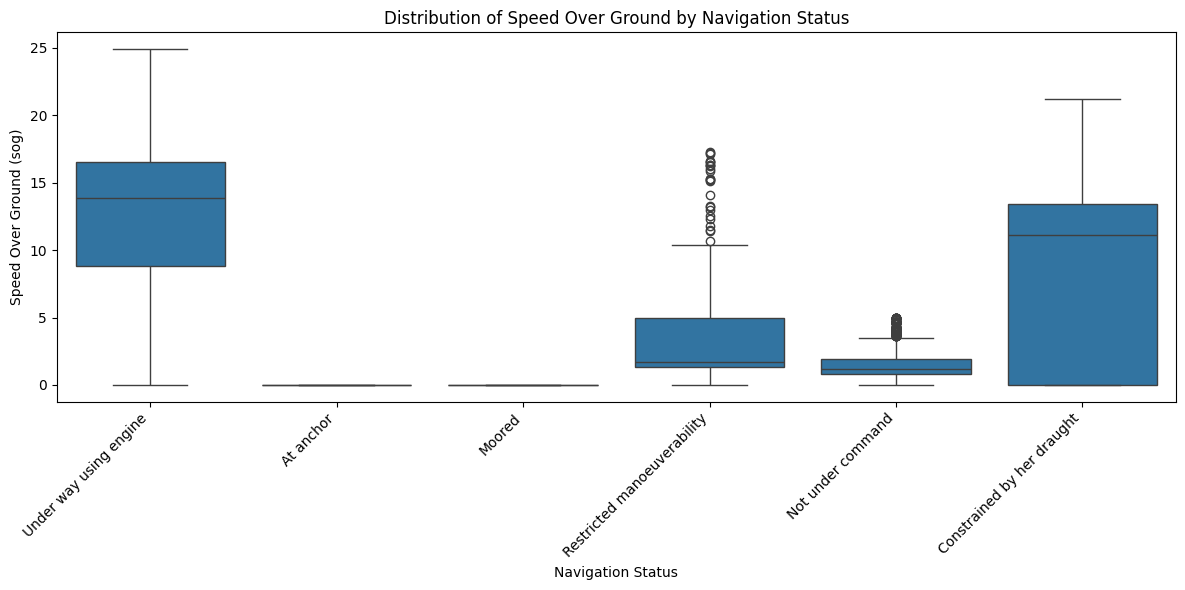

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map the numeric navstat values to their descriptive names
ais_train['navstat_description'] = ais_train['navstat'].map(navstat_mapping)

# Filter data to include only the navstat descriptions we're interested in (e.g., navstat < 6)
filtered_data = ais_train[ais_train['navstat'] < 6]

# Create a box plot to visualize the distribution of sog for each navstat description
plt.figure(figsize=(12, 6))
sns.boxplot(x='navstat_description', y='sog', data=filtered_data)
plt.xlabel('Navigation Status')
plt.ylabel('Speed Over Ground (sog)')
plt.title('Distribution of Speed Over Ground by Navigation Status')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

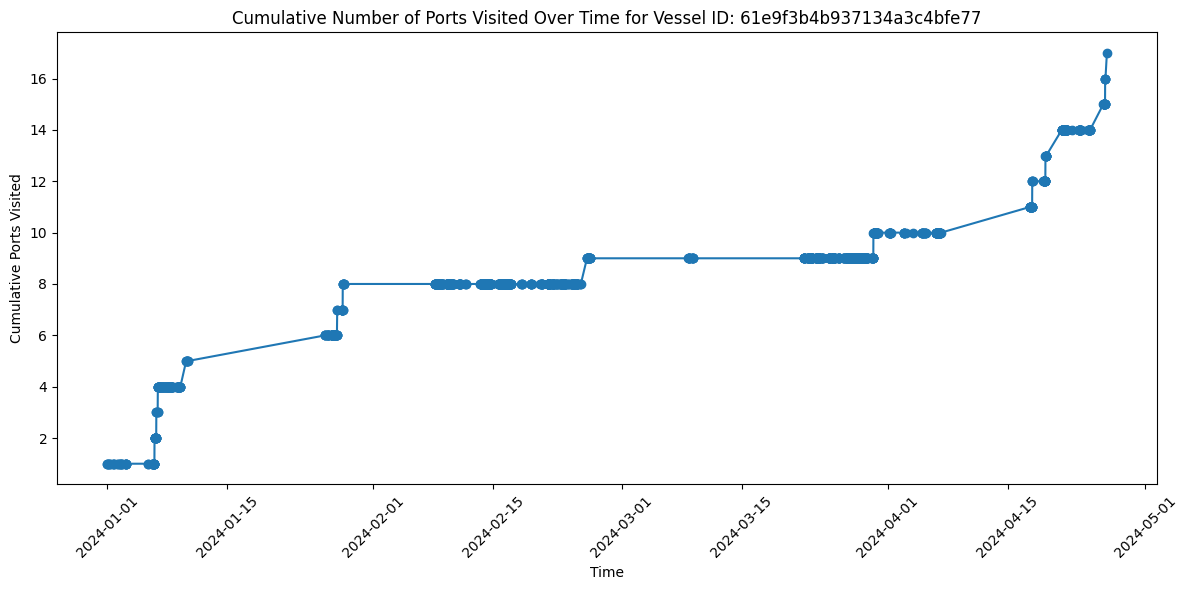

In [150]:
import matplotlib.pyplot as plt

# Get the first vesselId in the dataset
first_vessel_id = ais_train['vesselId'].iloc[0]

# Filter the data for only the first vesselId
first_vessel_data = ais_train[ais_train['vesselId'] == first_vessel_id]

# Sort the data by time for correct plotting order
first_vessel_data = first_vessel_data.sort_values(by='time')

# Calculate the cumulative count of unique ports visited over time
visited_ports = set()
cumulative_ports = []

for port in first_vessel_data['portId']:
    visited_ports.add(port)
    cumulative_ports.append(len(visited_ports))

first_vessel_data['cumulative_ports_visited'] = cumulative_ports

# Plot the cumulative number of ports visited over time for the first vessel
plt.figure(figsize=(12, 6))
plt.plot(first_vessel_data['time'], first_vessel_data['cumulative_ports_visited'], marker='o')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Cumulative Ports Visited')
plt.title(f'Cumulative Number of Ports Visited Over Time for Vessel ID: {first_vessel_id}')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [149]:
schedules = pd.read_csv("schedules_to_may_2024.csv", sep='|')[['portId', 'vesselId', 'portLatitude', 'portLongitude', 'arrivalDate', 'sailingDate']]
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'])
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'])
schedules = schedules.drop_duplicates(subset=['portId', 'arrivalDate', 'sailingDate', 'vesselId'])
schedules['portId'] = schedules['portId'].astype(str)

i = 0
for _, vessel in vessels.iterrows():
    vessel_schedule = schedules[schedules['vesselId'] == vessel['vesselId']]
    if len(vessel_schedule) == 0:
        continue

    break

In [192]:
# Prepare input and output features
features = ['new_id', 'elapsed_time']
target_columns = ['cog', 'sog', 'navstat', 'latitude', 'longitude']

# Extract and scale input and output data
input_data = ais_train[features].values
output_data = ais_train[target_columns].values

scaler_input = MinMaxScaler()
scaled_input = scaler_input.fit_transform(input_data)

scaler_output = MinMaxScaler()
scaled_output = scaler_output.fit_transform(output_data)

# Define time_step and create sequences
time_step = 10  # You can adjust this value

def create_sequences(input_data, output_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        y.append(output_data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_input, scaled_output, time_step)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Define the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Prepare the test data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# (Assuming you've already loaded and preprocessed ais_train and trained the model)

# Prepare the test data
ais_test = pd.read_csv("ais_test.csv")
ais_test['time'] = pd.to_datetime(ais_test['time'])
ais_test['elapsed_time'] = (ais_test['time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
ais_test['new_id'] = ais_test['vesselId'].map(vessel_id_to_new_id)

# Sort the test data
ais_test = ais_test.sort_values(by=['new_id', 'elapsed_time'])

# Extract and scale test input data
input_data_test = ais_test[features].values
scaled_input_test = scaler_input.transform(input_data_test)

# Create sequences for the test data with padding
def create_test_sequences(input_data, time_steps):
    X_test = []
    for i in range(len(input_data)):
        if i < time_steps:
            seq = np.zeros((time_steps, input_data.shape[1]))
            seq[-(i+1):] = input_data[:i+1]
        else:
            seq = input_data[i - time_steps + 1:i + 1]
        X_test.append(seq)
    return np.array(X_test)

X_test = create_test_sequences(scaled_input_test, time_step)

# Make predictions
y_pred = model.predict(X_test)

# Inverse the scaling of predictions
y_pred_inverse = scaler_output.inverse_transform(y_pred)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'ID': ais_test['ID'].values,
    'longitude_predicted': y_pred_inverse[:, target_columns.index('longitude')],
    'latitude_predicted': y_pred_inverse[:, target_columns.index('latitude')]
})

# Verify the length
if len(submission_df) != 51739:
    raise Exception("Must have 51739 in submission!")

# Save the submission file
submission_df.to_csv("submission.csv", index=False)

# Display the submission DataFrame
print(submission_df.head())
print(f"Submission DataFrame shape: {submission_df.shape}")


/Users/johansolbakken/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35211/35211 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - loss: 0.0571 - val_loss: 0.0561
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
    ID  longitude_predicted  latitude_predicted
0    4            14.370127           37.240597
1  201            13.894657           36.760548
2  583            13.630664           36.468582
3  701            13.495901           36.305504
4  829            13.428065           36.217239
Submission DataFrame shape: (51739, 3)


In [193]:
# Load the submission file to check min and max values
submission_df = pd.read_csv("submission.csv")

# Calculate the min and max values for longitude and latitude predictions
min_longitude = submission_df['longitude_predicted'].min()
max_longitude = submission_df['longitude_predicted'].max()
min_latitude = submission_df['latitude_predicted'].min()
max_latitude = submission_df['latitude_predicted'].max()

(len(submission_df),min_longitude, max_longitude, min_latitude, max_latitude)

(51739, 13.203605, 14.370127, 36.1045, 37.240597)